In [57]:
import pandas as pd
import numpy as np
import os
import tqdm
import regex as re
import tiktoken
import matplotlib.pyplot as plt

In [36]:
def bootstrap_ci(scores, n_bootstrap=10000, confidence_level=95):
    n_samples = len(scores)
    bootstrap_means = []
    for _ in range(n_bootstrap):
        resampled_scores = np.random.choice(scores, size=n_samples, replace=True)
        bootstrap_means.append(np.mean(resampled_scores))
    bootstrap_means = np.array(bootstrap_means)
    mean_score = np.mean(bootstrap_means)
    std_score = np.std(bootstrap_means)    
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    return mean_score, std_score, ci_lower, ci_upper

def categorize_body_group(exam_type):
    categories = {
        "Brain": ["HEAD", "BRAIN", "STROKE PROTOCOL", "NEURO"],
        "Abdomen/Pelvis": ["ABDOMEN", "PELVIS", "PROSTATE", "RENAL", "MRCP", "UROGRAM"],
        "MSK": ["KNEE", "HIP", "SHOULDER", "EXTREMITY", "SPINE", "LUMBAR", 
                "CERVICAL", "SCOLIOSIS", "JOINT"],
        "Chest": ["CHEST", "CARDIAC", "PULMONARY EMBOLISM", "CTA", "HEART"],
        "Head/Neck": ["FACE", "NECK", "CRANIOFACIAL", "MAXILLOFACIAL", "ORBIT", "TEMPORAL BONE", 
                 "SINUS", "THYROID", "MANDIBLE", "SKULL"]
    }
    
    for category, keywords in categories.items():
        if any(keyword in exam_type for keyword in keywords):
            return category
    return "Other"

def categorize_imaging_modality(exam_type):
    categories = {
        "MRI": ["MR", "MRI"],
        "CT": ["CT", "CTA"],
        "XR": ["XR"],
        "US": ["US"]
    }
    
    for category, keywords in categories.items():
        if any(keyword in exam_type for keyword in keywords):
            return category
    return "Other"

## Table S2: Prompt Engineering and Temperature Ablations

In [37]:
!ls /mnt/sohn2022/Adrian/rad-llm-pmhx/experiments/results/scores

llm_development_dataset


In [38]:
BASEPATH = "/mnt/sohn2022/Adrian/rad-llm-pmhx/experiments/results/scores/llm_development_dataset"
MODEL = "gpt4o"
NUM_SAMPLES = 100
PROMPT_ENGINEERING_EXPERIMENTS = [
    "zero_shot_standard",
    "zero_shot_augmented",
    "one_shot_standard",
    "one_shot_augmented"
]
TEMPERATURE_EXPERIMENTS = [
    "temp_0.0",
    "temp_0.5",
    "temp_1.0"
]
METRICS = ["rouge", "medcon", "radgraph", "bertscore"]

In [39]:
def _scale_metrics_inplace(df, metric_names):
    """Multiply all metrics by 100."""
    for m in metric_names:
        df[m] = pd.to_numeric(df[m], errors="coerce") * 100

def _fmt_stats(mu, lo, hi, signed=False):
    if signed:
        return f"{mu:+.2f} [{lo:+.2f},{hi:+.2f}]"
    return f"{mu:.2f} [{lo:.2f},{hi:.2f}]"

# ----- Prompt Engineering -----
results = []

baseline_scores = pd.read_csv(f"{BASEPATH}/{MODEL}/zero_shot_standard/results_{NUM_SAMPLES}.csv")
_scale_metrics_inplace(baseline_scores, METRICS)

for experiment in PROMPT_ENGINEERING_EXPERIMENTS:
    exp_scores = pd.read_csv(f"{BASEPATH}/{MODEL}/{experiment}/results_{NUM_SAMPLES}.csv")
    _scale_metrics_inplace(exp_scores, METRICS)

    row = {"Condition": experiment}
    for m in METRICS:
        mu, std, lo, hi = bootstrap_ci(exp_scores[m])
        row[m] = _fmt_stats(mu, lo, hi, signed=False)
    results.append(row)

ordered_cols = ["Condition"] + METRICS
table_df = pd.DataFrame(results)[ordered_cols]
table_df["Condition"] = table_df["Condition"].str.replace("augmented", "context_adaptive")
print(table_df)

# ----- Temperature Ablations -----
temp_rows = []
for experiment in TEMPERATURE_EXPERIMENTS:
    exp_scores = pd.read_csv(f"{BASEPATH}/{MODEL}/{experiment}/results_{NUM_SAMPLES}.csv")
    _scale_metrics_inplace(exp_scores, METRICS)

    row = {"Condition": experiment}
    for m in METRICS:
        mu, std, lo, hi = bootstrap_ci(exp_scores[m])
        row[m] = _fmt_stats(mu, lo, hi, signed=False)
    temp_rows.append(row)

table_df_temp = pd.DataFrame(temp_rows)[ordered_cols]
print(table_df_temp)

                    Condition                rouge               medcon  \
0          zero_shot_standard    9.49 [8.07,11.04]  13.30 [11.00,15.76]   
1  zero_shot_context_adaptive  20.04 [17.46,22.66]  23.90 [19.53,28.31]   
2           one_shot_standard  14.36 [12.36,16.51]  17.06 [14.06,20.19]   
3   one_shot_context_adaptive  21.10 [18.34,24.07]  27.43 [22.75,32.17]   

             radgraph            bertscore  
0    4.55 [3.03,6.29]  18.55 [15.81,21.20]  
1  10.08 [6.66,13.89]  31.80 [28.78,34.75]  
2   8.76 [6.25,11.51]  26.20 [23.19,29.13]  
3   9.69 [6.49,13.07]  34.31 [31.19,37.41]  
  Condition              rouge               medcon          radgraph  \
0  temp_0.0  9.49 [8.01,11.14]  13.23 [11.02,15.63]  5.07 [3.47,6.83]   
1  temp_0.5  9.38 [7.98,10.88]  13.56 [11.22,16.02]  5.11 [3.33,7.13]   
2  temp_1.0  9.13 [7.92,10.39]  13.18 [10.78,15.79]  5.28 [3.21,7.78]   

             bertscore  
0  18.57 [15.95,21.18]  
1  19.04 [16.31,21.79]  
2  19.00 [16.25,21.65]  


## Figure S3

In [40]:
intervals = [
    "0_10000",
    "10000_20000",
    "20000_30000",
    "30000_40000",
    "40000_50000",
    "50000_60000",
    "60000_70000",
    "70000_79032"
]

indication_dataset = []

for interval in tqdm.tqdm(intervals):
    parquet_path = f"/mnt/sohn2022/Adrian/rad-llm-pmhx/dataset/indication_dataset/raw/{interval}.parquet"
    indication_dataset.append(pd.read_parquet(parquet_path).reset_index(drop=True))
    
indication_dataset = pd.concat(indication_dataset) \
.drop_duplicates(subset=["radiology_deid_note_key"]) \
.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:58<00:00,  7.33s/it]


In [41]:
pathophysiological_intervals = [
    "llm_labels_pathophysiological_0_10000_2025-02-13_13-47-32.csv",
    "llm_labels_pathophysiological_10000_20000_2025-02-13_15-46-40.csv",
    "llm_labels_pathophysiological_20000_30000_2025-02-13_21-56-05.csv",
    "llm_labels_pathophysiological_30000_40000_2025-02-14_13-33-10.csv",
    "llm_labels_pathophysiological_40000_50000_2025-02-14_15-49-35.csv",
    "llm_labels_pathophysiological_50000_60000_2025-02-14_18-27-19.csv",
    "llm_labels_pathophysiological_60000_70000_2025-02-14_21-49-20.csv",
    "llm_labels_pathophysiological_70000_77984_2025-02-15_17-20-50.csv"
]

pathophysiological_labels = []

for interval in tqdm.tqdm(pathophysiological_intervals):
    csv_path = f"/mnt/sohn2022/Adrian/rad-llm-pmhx/dataset/pathophysiological_labels/{interval}"
    pathophysiological_labels.append(pd.read_csv(csv_path).reset_index(drop=True))
    
pathophysiological_labels = pd.concat(pathophysiological_labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 11.50it/s]


In [42]:
indication_dataset = (
    indication_dataset
    .merge(pathophysiological_labels)
    .drop_duplicates(subset=["radiology_deid_note_key"])
    .rename(columns={"generated_category": "pathophysiological_category"})
)
indication_dataset["pathophysiological_category"] = indication_dataset["pathophysiological_category"].replace({
    "cancer/mass": "Cancer/Mass",
    "surgical": "Surgical",
    "infection/inflammatory": "Infection/Inflammatory",
    "symptom-based": "Symptom-based",
    "structural": "Structural"
})
indication_dataset.loc[
    indication_dataset["exam_type"].notna(), "body_system"
] = indication_dataset.loc[indication_dataset["exam_type"].notna()]["exam_type"].apply(categorize_body_group)

In [43]:
_TIMESTAMP_RE = re.compile(
    r"^\d{1,2}/\d{1,2}/\d{4}\s+\d{1,2}:\d{2}\s*(?:AM|PM)$"
)

def extract_timestamp(s):
    if not isinstance(s, str):
        return None

    candidates = []

    # Method 1
    part = s.split("    ")[0]
    pieces = part.split(":", 1)
    if len(pieces) > 1:
        candidates.append(pieces[1].strip().split("  ")[0])

    # Method 2
    pieces = part.split("  ", 1)
    if len(pieces) > 1:
        candidates.append(pieces[1].strip().split("  ")[0])

    # Method 3
    alt = s.split("    ")
    if len(alt) > 1:
        candidates.append(alt[1].strip())

    # Validate each candidate
    for r in candidates:
        if len(r) >= 18 and _TIMESTAMP_RE.fullmatch(r):
            return r

def filter_notes_before_report(row):
    dates       = pd.to_datetime(row['deid_service_dates'], errors='coerce')
    report_date = pd.to_datetime(row['radiology_report_date'], errors='coerce')
    mask = dates < report_date
    filtered = {
        'note_texts'        : [d for d, keep in zip(row['note_texts'], mask)    if keep],
        'enc_dept_names'    : [d for d, keep in zip(row['enc_dept_names'], mask)    if keep],
        'note_types'        : [t for t, keep in zip(row['note_types'], mask)        if keep],
        'auth_prov_types'   : [p for p, keep in zip(row['auth_prov_types'], mask)   if keep],
        'deid_service_dates': [s for s, keep in zip(row['deid_service_dates'], mask) if keep],
    }
    return pd.Series(filtered)

indication_dataset_reader_study = indication_dataset.copy()
raw_times = indication_dataset_reader_study["radiology_text"].apply(extract_timestamp)
indication_dataset_reader_study['radiology_report_date'] = pd.to_datetime(
    raw_times,
    format='%m/%d/%Y %I:%M %p',   
    errors='coerce'                
)

filtered = indication_dataset_reader_study.apply(filter_notes_before_report, axis=1, result_type='expand')

indication_dataset_reader_study[[
    'note_texts',
    'enc_dept_names',
    'note_types',
    'auth_prov_types',
    'deid_service_dates'
]] = filtered

indication_dataset_reader_study = indication_dataset_reader_study[
    indication_dataset_reader_study["note_texts"].apply(len) > 0
].reset_index(drop=True)

In [44]:
RANDOM_STATE = 123
MIN_LENGTH = 200

BODY_SYSTEMS = ["Brain", "Head/Neck", "MSK", "Abdomen/Pelvis", "Chest"]
PATHOPHYSIOLOGICAL_CATEGORIES = ["Cancer/Mass", "Symptom-based", "Surgical", "Infection/Inflammatory", "Structural"]

def average_note_length(notes):
    average = 0
    for note in notes:
        average += len(note.split())
    return average / len(notes)

def stratify(dataset, total_samples):
    n_samples = total_samples // (len(BODY_SYSTEMS) * len(PATHOPHYSIOLOGICAL_CATEGORIES))
    stratified_dataset = []
    for body_system in BODY_SYSTEMS:
        for pathophysiological_category in PATHOPHYSIOLOGICAL_CATEGORIES:
            subset = dataset[
                (dataset["body_system"] == body_system) & 
                (dataset["pathophysiological_category"] == pathophysiological_category)
            ].sample(
                n=n_samples, random_state=RANDOM_STATE
            ).reset_index(drop=True)
            stratified_dataset.append(subset)
    return pd.concat(stratified_dataset).sample(frac=1).reset_index(drop=True)

llm_automated_test_dataset = stratify(indication_dataset, total_samples=1000)
print("LLM Automated Test Dataset")
print(
    llm_automated_test_dataset["patientdurablekey"].nunique(),
    llm_automated_test_dataset["radiology_deid_note_key"].nunique(),
    llm_automated_test_dataset["note_texts"].apply(len).sum()
)
print("-" * 20)

subset = indication_dataset_reader_study[indication_dataset_reader_study["note_texts"].apply(average_note_length) > MIN_LENGTH]
clinical_reader_study_test_dataset = stratify(subset, total_samples=250)
print("Reader Evaluation Dataset")
print(
    clinical_reader_study_test_dataset["patientdurablekey"].nunique(),
    clinical_reader_study_test_dataset["radiology_deid_note_key"].nunique(),
    clinical_reader_study_test_dataset["note_texts"].apply(len).sum()
)

LLM Automated Test Dataset
962 1000 9505
--------------------
Reader Evaluation Dataset
247 250 2127


In [65]:
clinical_reader_study_test_dataset["total_tokens"] = (
    clinical_reader_study_test_dataset["note_texts"]
    .apply(lambda notes: sum(len(enc.encode(note)) for note in notes))
)

llm_automated_test_dataset["total_tokens"] = (
    llm_automated_test_dataset["note_texts"]
    .apply(lambda notes: sum(len(enc.encode(note)) for note in notes))
)


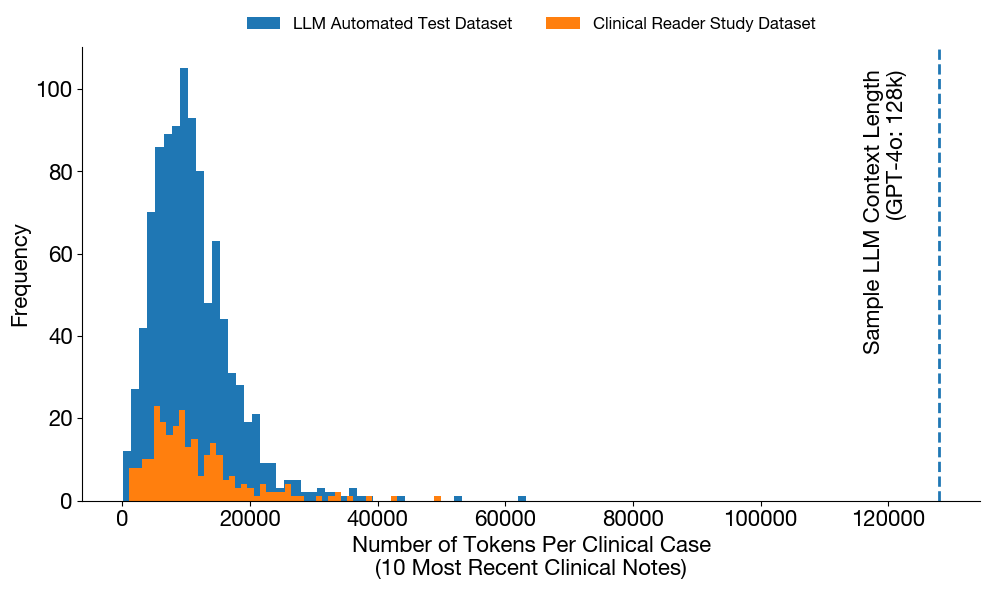

In [77]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# =========================
# Fonts (match Fig 6)
# =========================
font_path = "fonts/HelveticaNeue.ttf"
F_TICK  = fm.FontProperties(fname=font_path, size=16)
F_LABEL = fm.FontProperties(fname=font_path, size=16)
F_LEG   = fm.FontProperties(fname=font_path, size=12)

# =========================
# Data
# =========================
tokens_reader = clinical_reader_study_test_dataset["total_tokens"]
tokens_llm    = llm_automated_test_dataset["total_tokens"]

# Shared bins for comparability
bins = 50

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    tokens_llm,
    bins=bins,
    alpha=1,
    label="LLM Automated Test Dataset"
)

ax.hist(
    tokens_reader,
    bins=bins,
    alpha=1,
    label="Clinical Reader Study Dataset"
)



# Sample LLM context window reference (GPT-4o)
ax.axvline(
    x=128_000,
    linestyle="--",
    linewidth=2
)

# Context window label (offset from line)
ax.text(
    128_000 - 5_000,
    ax.get_ylim()[1] * 0.95,
    "Sample LLM Context Length\n(GPT-4o: 128k)",
    rotation=90,
    va="top",
    ha="right",
    fontproperties=F_LABEL
)

# Axis labels
ax.set_xlabel("Number of Tokens Per Clinical Case\n(10 Most Recent Clinical Notes)", fontproperties=F_LABEL)
ax.set_ylabel("Frequency", fontproperties=F_LABEL)

# Tick font styling
for tick in ax.get_xticklabels():
    tick.set_fontproperties(F_TICK)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(F_TICK)

# Spines: left + bottom only
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

# Legend
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=2,
    frameon=False,
    prop=F_LEG
)

# Clean style
ax.grid(False)

# Layout + save
fig.tight_layout()
fig.savefig(
    "figures/figS3_token_count_distribution_two_datasets.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()